# Energy Consumption Forecast

Table of Contents:

1. Data Analysis
    - Data Description
    - Data Loading
    - Exploratory Data Analysis (EDA)
        - Correlation Heatmap
        - Relationship between variables
        - Scatter-matrix
        - Distribution Plots
        - Box Plots
        - Count Plots
    - Data Preprocessing
2. Machine Learning
    - Model Selection
    - Hyperparameter tuning
3. Conclusions

**Problem Statement**: The volatile energy market is unsure of future energy consumption. Departments of Energy Need expert opinion on the future demand of electrical energy in the Eastern part of the US.

**Objective**: Train a Machine Learning Model to predict energy consumption in the future based on current data. Backtest the model.

## Data Description

Source: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

The data has 145366 entries for energy consumption of the Eastern part of the US as handled by PMJ (PJM Interconnection LLC), a regional transmission organization coordinating the transfer of electricity across multiple power grids in America. The columns in this dataset are:

- Datetime (hourly from December 2002 to February 2018)
- PJME_MW (Current reading of energy transfered per unit of time in Megawatts)

In [38]:
#Loading libraries and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
import numpy as np

import xgboost as xgb

In [39]:
data = pd.read_csv('PJME_hourly.csv')
data

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [41]:
#Check for null values
data.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

In [42]:
#Check for duplicates
data.duplicated().sum()

0

In [43]:
#Reindexing data by date
data.set_index('Datetime')

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [44]:
#Changing object type
data['Datetime'] = pd.to_datetime(data['Datetime'] )

<function matplotlib.pyplot.show(close=None, block=None)>

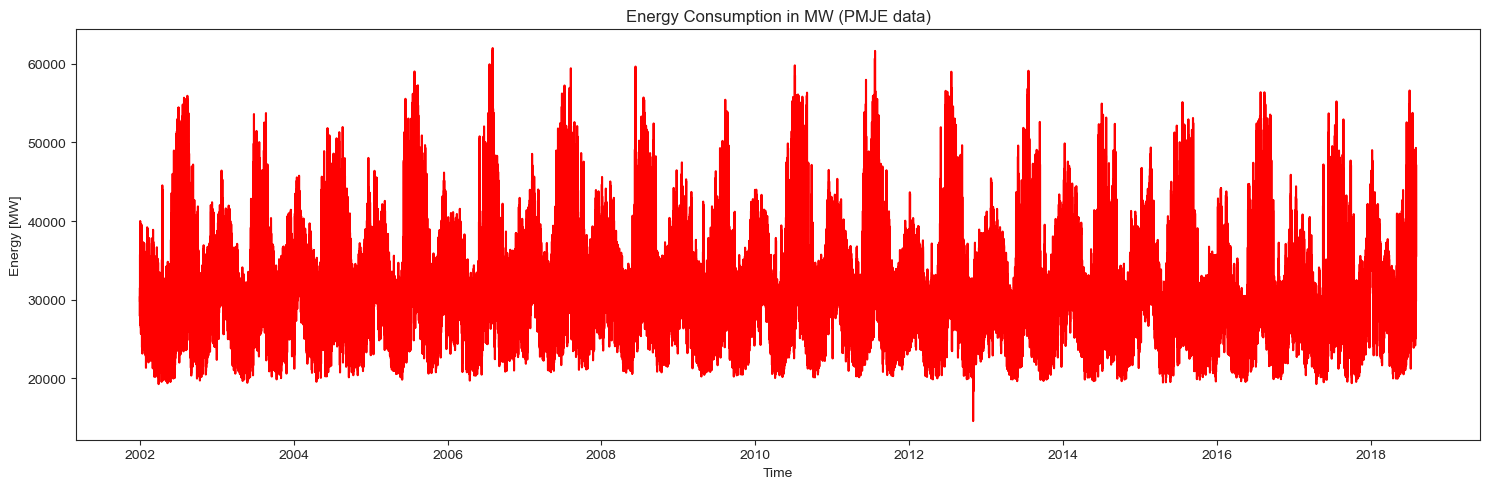

In [48]:
fig = plt.figure(figsize=(15,5))
sns.lineplot(data=data, x='Datetime', y='PJME_MW', color='r')
plt.title('Energy Consumption in MW (PMJE data)')
plt.xlabel('Time')
plt.ylabel('Energy [MW]')
plt.tight_layout()
plt.savefig('images/01_EnergyTime.png', bbox_inches='tight')
plt.show

For training our model, we will use 80% of all data. This means that data from 2002 to 2015 will be used for training, while we will use the remaining data for cross-validation and testing. 

In [56]:
train = data.loc['Datetime' < '01-01-2015']
test = data.loc['Datetime' >= '01-01-2015']

KeyError: 'False: boolean label can not be used without a boolean index'